In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

# === Funciones ===

def VBS(S0, K, T, r, q, sigma, epsilon):
    d1 = (np.log(S0 / K) + (r - q) * T) / (sigma * np.sqrt(T)) + sigma * np.sqrt(T) / 2
    d2 = d1 - sigma * np.sqrt(T)
    return epsilon * S0 * np.exp(-q * T) * norm.cdf(epsilon * d1) - epsilon * K * np.exp(-r * T) * norm.cdf(epsilon * d2)

def cn_scheme(N, A, TG, deltat, payoff):
    V = np.zeros((N, len(TG)))
    V[:, 0] = payoff

    I = np.eye(N)
    M1 = np.linalg.inv(I - (deltat / 2) * A)
    M2 = I + (deltat / 2) * A

    for i in range(1, len(TG)):
        V[:, i] = M1 @ (M2 @ V[:, i - 1])

    return V

def implicit_scheme(N, A, TG, deltat, payoff):
    V = np.zeros((N, len(TG)))
    V[:, 0] = payoff

    I = np.eye(N)
    M = np.linalg.inv(I - deltat * A)

    for j in range(1, len(TG)):
        V[:, j] = M @ V[:, j - 1]

    return V

def getAmericanStraddle(N, K, A, SG, payoff, TG, deltat):
    W = np.zeros((N, len(TG)))
    W[:, 0] = payoff

    I = np.eye(N)
    M = np.linalg.inv(I - (A * deltat / 2)) @ (I + (A * deltat / 2))

    for i in range(1, len(TG)):
        cont = M @ W[:, i - 1]
        exe = np.abs(np.maximum(SG - K, 0) - np.maximum(K - SG, 0))
        W[:, i] = np.maximum(cont, exe)

    return W

In [2]:
# === Parámetros del mercado ===

S0 = 460
r = 0.05
q = 0.01
sigma = 0.25

# === Parámetros de la opción ===

K = 500
T = 10

# Valor de la Call y Put
V_Call = VBS(S0, K, T, r, q, sigma, 1)
V_Put = VBS(S0, K, T, r, q, sigma, -1)
V_Straddle = V_Call + V_Put

Text(0.5, 1.0, 'Payoff en función del Spot')

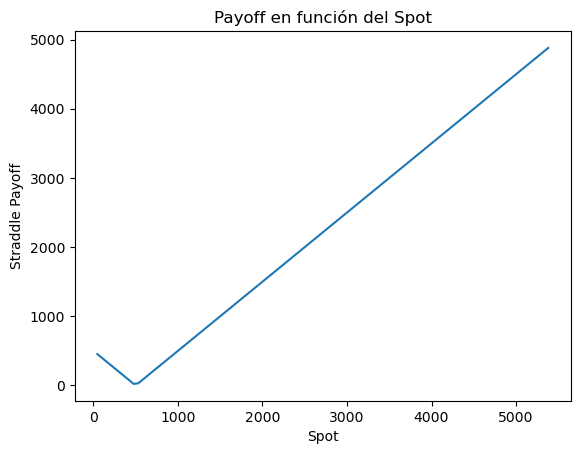

In [3]:
# Calculamos el spacegrid

Smin = S0 * np.exp(((r - q) - sigma ** 2 / 2) * T - 3 * sigma * np.sqrt(T))
Smax = S0 * np.exp(((r - q) - sigma ** 2 / 2) * T + 3 * sigma * np.sqrt(T))
N = 100
SG = np.linspace(Smin, Smax, N)
payoff = np.abs(SG - K)

# Gráfico del payoff
plt.figure(1)
plt.plot(SG, payoff)
plt.xlabel('Spot')
plt.ylabel('Straddle Payoff')
plt.title('Payoff en función del Spot')

In [4]:
# Matriz A

deltaS = (Smax - Smin) / (N - 1)
A = np.zeros((N, N))

A[0, 0] = - (r - q) * SG[0] / deltaS - r
A[0, 1] = (r - q) * SG[0] / deltaS
A[-1, -2] = - (r - q) * SG[-1] / deltaS
A[-1, -1] = (r - q) * SG[-1] / deltaS - r

for j in range(1, N - 1):
    A[j, j - 1] = - ((r - q) * SG[j]) / (2 * deltaS) + 0.5 * (sigma ** 2 * SG[j] ** 2) / (deltaS ** 2)
    A[j, j] = - (sigma ** 2 * SG[j] ** 2) / (deltaS ** 2) - r
    A[j, j + 1] = ((r - q) * SG[j]) / (2 * deltaS) + 0.5 * (sigma ** 2 * SG[j] ** 2) / (deltaS ** 2)

In [5]:
# === Grid temporal ===

deltat = 0.5
TG = np.arange(0, T + deltat, deltat)


Text(0.5, 1.0, 'Valores de esquema Crank-Nicolson contra precio spot')

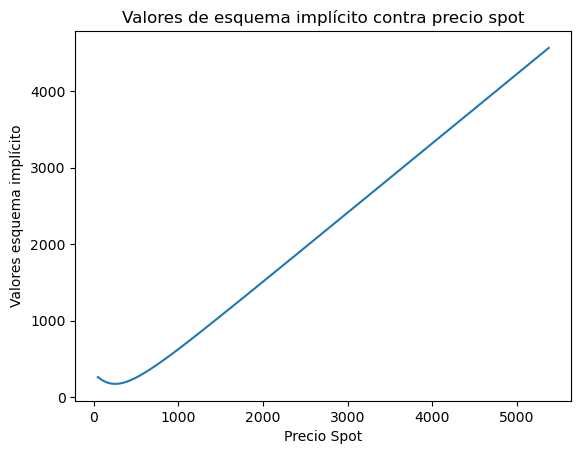

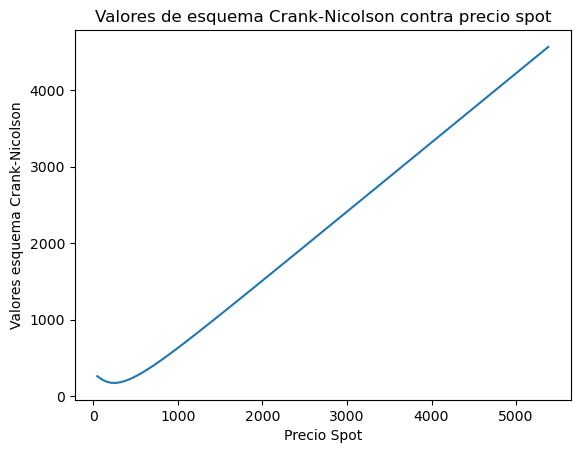

In [6]:
# === Esquemas numéricos ===

V_implicit = implicit_scheme(N, A, TG, deltat, payoff)
V_cn = cn_scheme(N, A, TG, deltat, payoff)

plt.figure(2)
plt.plot(SG, V_implicit[:, -1])
plt.xlabel('Precio Spot')
plt.ylabel('Valores esquema implícito')
plt.title("Valores de esquema implícito contra precio spot")

plt.figure(3)
plt.plot(SG, V_cn[:, -1])
plt.xlabel('Precio Spot')
plt.ylabel('Valores esquema Crank-Nicolson')
plt.title("Valores de esquema Crank-Nicolson contra precio spot")

Text(0.5, 1.0, 'Errores de los esquemas')

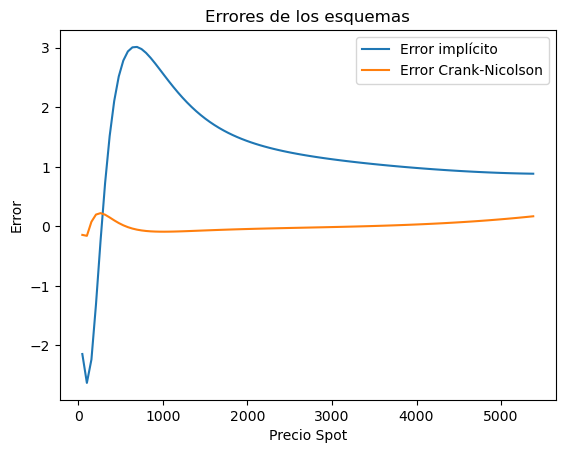

In [7]:
# === Comparación con Black-Scholes ===

V_BS = np.array([VBS(s, K, T, r, q, sigma, -1) + VBS(s, K, T, r, q, sigma, 1) for s in SG])
implicit_error = V_BS - V_implicit[:, -1]
cn_error = V_BS - V_cn[:, -1]

plt.figure(5)
plt.plot(SG, implicit_error, label='Error implícito')
plt.plot(SG, cn_error, label='Error Crank-Nicolson')
plt.xlabel('Precio Spot')
plt.ylabel('Error')
plt.legend()
plt.title('Errores de los esquemas')

In [8]:
# === Interpolación del valor en S0 ===

print("El valor en S0 a través del esquema ímplicito es: ", interp1d(SG, V_implicit[:, -1])(S0))
print("El valor en S0 a través del esquema Crank-Nicolson es: ", interp1d(SG, V_cn[:, -1])(S0))

El valor en S0 a través del esquema ímplicito es:  235.68175588858765
El valor en S0 a través del esquema Crank-Nicolson es:  237.99253716743667


Text(0.5, 1.0, 'American vs European straddle')

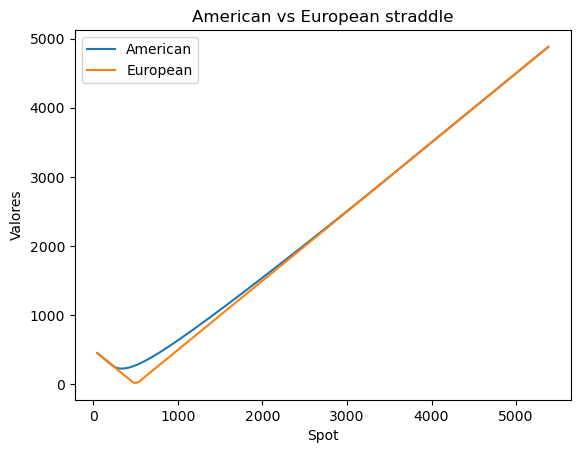

In [9]:
# === Opción Americana ===

WCN = getAmericanStraddle(N, K, A, SG, payoff, TG, deltat)
WCN0 = interp1d(SG, WCN[:, -1])(S0)

plt.figure(6)
plt.plot(SG, WCN[:, -1], label='American')
plt.plot(SG, payoff, label='European')
plt.xlabel('Spot')
plt.ylabel('Valores')
plt.legend()
plt.title('American vs European straddle')

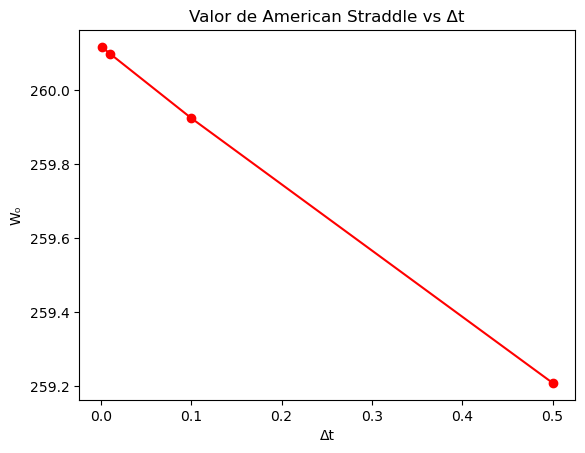

In [10]:
# === Convergencia en Δt ===

dt_values = [0.5, 0.1, 0.01, 0.001]
VA_11 = np.zeros((2, len(dt_values)))

for i, dt in enumerate(dt_values):
    TimeGrid = np.arange(0, T + dt, dt)
    VA_11[1, i] = dt
    VA_11_2 = getAmericanStraddle(N, K, A, SG, payoff, TimeGrid, dt)
    VA_11[0, i] = interp1d(SG, VA_11_2[:, -1])(S0)

plt.figure(8)
plt.plot(VA_11[1], VA_11[0], '-or')
plt.xlabel('Δt')
plt.ylabel('W₀')
plt.title('Valor de American Straddle vs Δt')

plt.show()